# 0.3 BP Model in Tensorflow

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Sun Mar 03 2019 01:37:24 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : edd22d45c1c38e765037bf04d03c4caf4494dc66
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [410]:
# Standard library imports
import os
import logging
from functools import reduce

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [41]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_MODELS

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [45]:
# Run base logger setup
# setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

tf.logging.set_verbosity(logging.INFO)

### Global Variables

#### Combigen Task Variables

In [9]:
# Number of slots in a training set
STACK = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2

#### Data Parameters

In [10]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN= 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

In [11]:
# Training Data
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, stack=STACK, size=SIZE, dims=DIMS)
X_TRAIN = cg.inverse_transform(Y_TRAIN)
# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, stack=STACK, size=SIZE, dims=DIMS)
X_VAL = cg.inverse_transform(Y_VAL)
# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, stack=STACK, size=SIZE, dims=DIMS)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [79]:
# Learning rate
ALPHA = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = STACK * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = STACK * SIZE * DIMS

#### Training Parameters

In [479]:
# Number of times to print an update
N_UPDATES = 5
# Which device to train on
TF_DEVICE = '/cpu:0'

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. Skip around as needed.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

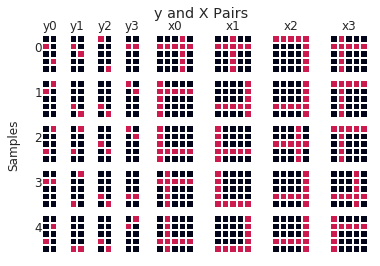

In [13]:
cgh.visualize_combigen(5)
plt.show()

### Keras Implementation

In nb-0.2.x, the O'Reilly BP model was implemented in keras with the code having this general structure:

```
def bp_model_bce(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer=optimizers.SGD(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model
```

With the main difference between models tested in nb-0.2.1 being the loss functions. The two most interesting models had the following training curves:

##### Binary cross-entropy loss with stochastic gradient descent


![BCE_SGD](images/nb0.2.1_bce_sgd_5000_epochs.png)


##### Mean-squared-error loss with stochastic gradient descent


![MSE_SGD](images/nb0.2.1_mse_sgd_5000_epochs.png)


Some things to note are that the models were trained to 10 times the number of epochs as O'Reilly did (500). However, a dotted vertical line was added at the 500 epoch mark to make it clear what the model's performance would have looked like.

## The Tensorflow Pipeline

Using the results of the keras implementation as the benchmark for this model, let's rewrite the model using pure tensorflow. Let's start by resetting the graph and then defining the weights and associated biases.

In [480]:
# Cleanup any residual nodes
tf.reset_default_graph()

### Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [481]:
# Weights and biases
weights = {
    'h1': tf.get_variable(name='w_h1', shape=[N_INPUTS, N_HIDDEN_1],
                      initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable(name='w_out', shape=[N_HIDDEN_1, N_OUTPUTS],
                      initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'b1': tf.get_variable(name="b_1", shape=[N_HIDDEN_1], 
                      initializer=tf.zeros_initializer()),
    'out': tf.get_variable(name="b_out", shape=[N_OUTPUTS], 
                      initializer=tf.zeros_initializer()),
}

# List for initialization operations
init_ops = [tf.global_variables_initializer()]

### Datasets

Now let's use the `tf.data` API to wrap our task data. 

The first step of the setup is that each of the datasets (training, validation, and testing) are turned into their own `Dataset` objects.

In [482]:
# Training dataset
dataset_train = tf.data.Dataset.from_tensor_slices(
    (X_TRAIN, Y_TRAIN)).repeat().batch(BATCH_SIZE)
# Validation dataset
dataset_val = tf.data.Dataset.from_tensor_slices(
    (X_VAL, Y_VAL)).repeat().batch(N_VAL)
# Testing dataset
dataset_test = tf.data.Dataset.from_tensor_slices(
    (X_TEST, Y_TEST)).repeat().batch(N_TEST)

Next, let's define the iterators for each of the datasets, and then add their initializations to the `init_ops` list.

In [483]:
# Training iterator
train_iter = dataset_train.make_initializable_iterator()
# Validation iterator
val_iter = dataset_val.make_initializable_iterator()
# Testing iterator
test_iter = dataset_test.make_initializable_iterator()

# Add the initiatlizations to the init opts
init_ops += [train_iter.initializer, val_iter.initializer, test_iter.initializer]

And finally, the interesting part.

Rather than creating separate next elements for the model, the `tf.data` API has a string handler iterator so we can contextually switch the active `Dataset` object, resulting in different values being used for `x` and `y`.

The way this is done is by defining a `tf.placeholder` variable, which is used first to create a string handler iterator, and later to hold the dataset-indicating string handle. The string handler iterator is what then changes the values of `x` and `y`, naturally also supplying them using the `get_next` method.

In [484]:
# The placeholder variable of type string
handle = tf.placeholder(tf.string, shape=[])
# Iterator from string handle
iterator = tf.data.Iterator.from_string_handle(
    handle, dataset_train.output_types, 
    dataset_train.output_shapes)

# x and y that will be used in the graph
x, y = iterator.get_next()

### O'Reilly Model

The architecture is the same as before, with one slight change. The output layer no longer has the sigmoid activation, but only because it is baked into the loss function `tf.nn.sigmoid_cross_entropy_with_logits`, which naturally takes in logits.

Note that when instantiating the model, `x` is passed in as the inputs.

In [485]:
def oreilly_model(inputs):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, N_INPUTS])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, STACK, SIZE, DIMS])

### The Loss Function

For the loss, we'll use binary cross entropy with vanilla gradient descent.

In [486]:
with tf.device(TF_DEVICE):
    # Build the model
    logits = oreilly_model(x)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=ALPHA)

    # train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    train_op = optimizer.minimize(loss_op)

### Metrics

The last few ops to define before training are the metrics. In particular, O'Reilly defines accuracy to be the fraction of samples where the model was on the correct side of 0.5 for all elements in the outputs.

In [487]:
with tf.device(TF_DEVICE):
    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)

    # O'Reilly Accuracy 
    correct_pred = tf.reduce_all(equal_labels_and_preds, axis=(1,2,3))
    accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float16))

    # Elemental Accuracy 
    el_accuracy_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float16))

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [488]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Training the Model

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [509]:
def train_or_model(sess, epochs=EPOCHS):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about
    metrics = {'loss':[], 'acc':[], 'el_acc':[], 
               'val_loss':[], 'val_acc':[], 'val_el_acc':[]}
    # Run the initialization ops
    sess.run(init_ops)
    # Define training and validation handlers
    training_handle, validation_handle, testing_handle = sess.run(
        [train_iter.string_handle(),
         val_iter.string_handle(),
         test_iter.string_handle()])

    for epoch in range(epochs):
        epoch_loss, epoch_acc, epoch_el_acc = np.zeros([3, N_TRAIN])
        # Run the training steps
        for i in range(N_TRAIN):
            _, epoch_loss[i], epoch_acc[i], epoch_el_acc[i] = sess.run(
                [train_op, loss_op, accuracy_op, el_accuracy_op],
                feed_dict={handle: training_handle})
            
        loss, acc, el_acc = np.mean((epoch_loss, epoch_acc, epoch_el_acc), axis=1)

        # Calculate validation accuracy and loss
        val_loss, val_acc, val_el_acc = sess.run([loss_op, accuracy_op, el_accuracy_op],
                                                 feed_dict={handle: validation_handle})
        # Record
        for key, value in zip(metrics.keys(), [loss, acc, el_acc, val_loss, val_acc, val_el_acc]):
            metrics[key].append(value)

        # Selectively display the epoch number
        if not epoch % (epochs / N_UPDATES) or epoch == epochs - 1:
            print(("Completed epoch {0}/{1}. Metrics:\n" + 
                   "                     Loss       Accuracy   Elem Accuracy\n" +
                   "    Epoch:      {2:10.4f}   {3:10.4f}   {4:10.4f}\n" +
                   "    Validation: {5:10.4f}   {6:10.4f}   {7:10.4f}\n").format(
                      epoch+1, epochs, loss, acc, el_acc, val_loss, val_acc, val_el_acc))

    print("Optimization Finished!")
    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", sess.run(accuracy_op, feed_dict={handle: testing_handle}))
    return metrics

And now let's train for `EPOCHS` epochs.

In [503]:
%%time
sess = new_session()
metrics = train_or_model(sess, epochs=EPOCHS)

Completed epoch 1/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7072       0.0000       0.5708
    Validation:     0.6705       0.0000       0.6260

Completed epoch 11/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.5040       0.0000       0.7998
    Validation:     0.5096       0.0000       0.7998

Completed epoch 21/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4888       0.0000       0.7998
    Validation:     0.5007       0.0000       0.7998

Completed epoch 31/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4834       0.0000       0.7998
    Validation:     0.4981       0.0000       0.7998

Completed epoch 41/50. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4789       0.0000       0.7998
    Validation:     0.4954       0.0000       0.7998

Completed epoch 50/50

## Recreating the BCE+E Training Curves

Just like before, let's plot the training curves using the metrics we obtained. To do this, let's borrow the same function we had earlier but make a slight adjustment to it works for plain dictionaries.

In [501]:
def plot_history(history):
    metrics = history if not hasattr(history, 'history') else history.history
    for key, array in metrics.items():
        plt.plot(array, label=key)
    plt.title('Training History')
    plt.xlabel('Epochs')
    if len(array) > EPOCHS:
        plt.axvline(EPOCHS, linestyle='--', label='500 Epochs')
    plt.legend()

This function will now work for both keras history objects and dictionaries.

### The Legend

One quick thing to go over for the proceeding graphs is the legend. Below are the definitions for them:

- `loss` - Loss for the training set for a particular epoch
- `acc` - Accuracy as defined by O'Reilly for the training set for a particular epoch
- `el_acc` - Element-wise accuracy between predictions and labels for the training set for that epoch
- `val_loss` - Loss for the validation set for a particular epoch
- `val_acc` - Accuracy as defined by O'Reilly for the validation for a particular epoch
- `val_el_acc` - Element-wise accuracy between predictions and labels for the validation set for a particular  epoch

### 500 Epochs

Start the plot for just 500 epochs.

In [527]:
%%time
sess = new_session()
metrics = train_or_model(sess, epochs=EPOCHS)

Completed epoch 1/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7023       0.0000       0.5130
    Validation:     0.6680       0.0000       0.5752

Completed epoch 101/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4520       0.0000       0.7998
    Validation:     0.4764       0.0000       0.7998

Completed epoch 201/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.4025       0.0000       0.8026
    Validation:     0.4413       0.0000       0.8003

Completed epoch 301/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.3497       0.0000       0.8245
    Validation:     0.4038       0.0000       0.8076

Completed epoch 401/500. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.3009       0.0000       0.8638
    Validation:     0.3681       0.0000       0.8232

Completed ep

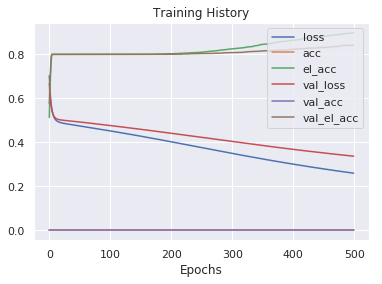

In [528]:
plot_history(metrics)
plt.show()

### 10 x 500 Epochs

Let's recreate the same plot shown above for the O'Reilly model when running for ten times as many epochs.

In [529]:
%%time
sess = new_session()
metrics = train_or_model(sess, epochs=10*EPOCHS)

Completed epoch 1/5000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7112       0.0000       0.5335
    Validation:     0.6719       0.0000       0.5820

Completed epoch 1001/5000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.1371       0.4000       0.9780
    Validation:     0.2373       0.0200       0.9053

Completed epoch 2001/5000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0590       0.9700       0.9993
    Validation:     0.1594       0.1000       0.9404

Completed epoch 3001/5000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0344       1.0000       1.0000
    Validation:     0.1280       0.2000       0.9541

Completed epoch 4001/5000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0234       1.0000       1.0000
    Validation:     0.1112       0.2000       0.9614

Com

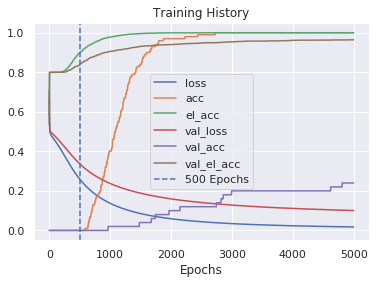

In [530]:
plot_history(metrics)
plt.show()

### 50 x 500 Epochs

It looks as though the model is still continuing to learn as shown by the increasing validation accuracy and falling validation loss. So train it for even longer.

In [512]:
metrics_1 = train_or_model(sess, epochs=50*EPOCHS)

Completed epoch 1/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.7033       0.0000       0.5765
    Validation:     0.6728       0.0000       0.5991

Completed epoch 5001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0175       1.0000       1.0000
    Validation:     0.1010       0.2000       0.9648

Completed epoch 10001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0074       1.0000       1.0000
    Validation:     0.0783       0.3000       0.9727

Completed epoch 15001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0046       1.0000       1.0000
    Validation:     0.0692       0.3401       0.9761

Completed epoch 20001/25000. Metrics:
                     Loss       Accuracy   Elem Accuracy
    Epoch:          0.0033       1.0000       1.0000
    Validation:     0.0640       0.3401       0.9

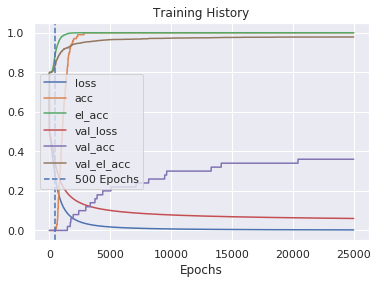

In [515]:
plot_history(metrics_1)
plt.show()